# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d # for interpolating points
from scipy.optimize import curve_fit # for curve fitting
from pylab import * # for color palettes
import math

# Define Functions

In [2]:
def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 0 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

# Load data

In [3]:
# Quercus macrocarpaa data
outline = np.loadtxt("./outline_quercus_macrocarpa.txt")
landmarks = np.loadtxt("./landmarks_quercus_macrocarpa.txt")
axis = np.loadtxt("./axis_quercus_macrocarpa.txt")

# Flip data
outline[:,1] = outline[:,1]*-1
landmarks[:,1] = landmarks[:,1]*-1
axis[:,1] = axis[:,1]*-1

# Analysis

In [4]:
#######################################################
### FIND OUTLINE AND AXIS INDICES FOR EACH LANDMARK ###
#######################################################

res = 7000 # resolution for outline and axis
lft_res = 100 # resolution for one side of leaflet
scale = 6.5 # for plotting, set a scale

# interpolate axis to desired resolution
inter_axis_x, inter_axis_y  = interpolation(axis[:,0],axis[:,1],res)
axis = np.column_stack((inter_axis_x, inter_axis_y))

# interpolate outline to desired resolution
inter_out_x, inter_out_y  = interpolation(outline[:,0],outline[:,1],res)
outline = np.column_stack((inter_out_x, inter_out_y))

num_lfts = int(len(landmarks)/3) # calculate number of leaflets, 3 landmarks/leaflet
lft_pts = np.reshape(landmarks, (num_lfts,3,2)) # reshape landmarks organized by leaflet

lft_out_ind = np.zeros((num_lfts,3)) # store corresponding outline indices for each landmark
lft_axis_ind = np.zeros((num_lfts,3)) # store corresponding axis indices for each landmark
for lft in range(num_lfts): # for each leaflet
    land_out_inds = np.zeros((3)) # store the landmark outline indices
    land_axis_inds = np.zeros((3)) # store the landmark axis indices
    for lnd in range(3): # for each of 3 landmarks
        out_dists = []
        axis_dists = []
        for pt in range(len(outline)): # for each outline and axis point
            # distance of each outline point to the current landmark
            out_dists.append(euclid_dist(lft_pts[lft,lnd,0],lft_pts[lft,lnd,1],outline[pt,0],outline[pt,1]))
            # distance of each axis point to the current landmark
            axis_dists.append(euclid_dist(lft_pts[lft,lnd,0],lft_pts[lft,lnd,1],axis[pt,0],axis[pt,1]))
        land_out_inds[lnd] = out_dists.index(min(out_dists)) # store landmark indices for outline
        land_axis_inds[lnd] = axis_dists.index(min(axis_dists)) # store landmark indices for axi
        
    lft_out_ind[lft,:] = land_out_inds # store landmarks for outline for each leaflet
    lft_axis_ind[lft,:] = land_axis_inds # store landmarks for axis for each leaflet

lft_out_ind = lft_out_ind.astype(int) # convert array of indices to integers
lft_axis_ind = lft_axis_ind.astype(int) # convert array of indices to integers

################################
### INTERPOLATE EACH LEAFLET ###
################################

lft_inter_arr = np.zeros((num_lfts,lft_res*2,2)) # a 3D array to store the interpolated x/y coordinates of each leaf

for lft in range(num_lfts):

    out_inds = lft_out_ind[lft] # get outline indices of current leaflet
    lft_left = outline[out_inds[0]:out_inds[1]] # start, up to not including the tip
    lft_right = outline[out_inds[1]:out_inds[2]+1] # tip, up to the end

    # interpolate left and right sides of leaflet and combine into single 2D array
    lft_left_inter_x, lft_left_inter_y = interpolation(lft_left[:,0],lft_left[:,1],lft_res)
    lft_right_inter_x, lft_right_inter_y = interpolation(lft_right[:,0],lft_right[:,1],lft_res) 
    lft_left_inter = np.column_stack((lft_left_inter_x, lft_left_inter_y))
    lft_right_inter = np.column_stack((lft_right_inter_x, lft_right_inter_y))
    lft_inter_arr[lft,:] = np.row_stack((lft_left_inter,lft_right_inter))

#####################################
### TRANSFORM LEAFLETS ALONG AXIS ###
#####################################

transf_lft = np.zeros((num_lfts,lft_res*2,2)) # a 3D array to store the transformed x/y coordinates of each leaf

for lft in range(num_lfts):

    curr_lft = lft_inter_arr[lft,:,:] # select current leaflet
    start_pt = curr_lft[0,:] # get start point
    end_pt = curr_lft[-1,:] # get end point
    mid_pt = np.mean((start_pt,end_pt),axis=0) # get mid point between start and end

    trans_lft = curr_lft-mid_pt # translate base of leaflet to origin

    ang = angle_between((trans_lft[-1,0],trans_lft[-1,1]),(0,0),(10,0)) # angle between end point, origin, and origin x+10

    rot_x, rot_y = rotate_points(trans_lft[:,0],trans_lft[:,1], ang) # rotate points so 90 degrees upright
    rot_x, rot_y = rot_x*scale, rot_y*scale # scale points

    axis_inds = lft_axis_ind[lft] # translate points to their corresponding axis point
    axis_mid_ind = int(np.mean((axis_inds[0],axis_inds[-1])))
    rot_x = rot_x + axis_mid_ind
    
    transf_lft[lft,:,0] = rot_x # store transformed points
    transf_lft[lft,:,1] = rot_y

#######################################
### RECONSTRUCT LEAFLETS ALONG AXIS ###
#######################################
     
coord_num = len(transf_lft[0]) # get number of coordinates for each leaf

x_arr = np.zeros((coord_num,3)) # for x vals: coords x 3 coefficients
y_arr = np.zeros((coord_num,3)) # for y vals: coords x 3 coefficients

# create a 2nd degree polynomial function
def polydeg2(xvals, a, b, c):
    return a*(xvals**2) + b*xvals +c

for coord in range(coord_num): # for each coord

    model_vals = np.arange(0,num_lfts,1) # calculate the leaflets to model over
    xvals = transf_lft[:,coord,0] # calculate x vals
    yvals = transf_lft[:,coord,1] # calculate y vals

    # calculate parameters for xvals and yvals
    x_par, x_cov = curve_fit(polydeg2, model_vals, xvals) # xval as a function of leaflet
    y_par, y_cov = curve_fit(polydeg2, model_vals, yvals) # yval as a function of leaflet

    # store xval and yval coefficients
    x_arr[coord,:] = x_par
    y_arr[coord,:] = y_par


# Plot original leaf

/var/folders/_x/9rzw8tw527l5dl39m6gjjskm0000gn/T/ipykernel_20912/4109820386.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', num_lfts)


(531.3472361419274, 789.4541722786364, -395.98825956464464, 10.753450857536947)

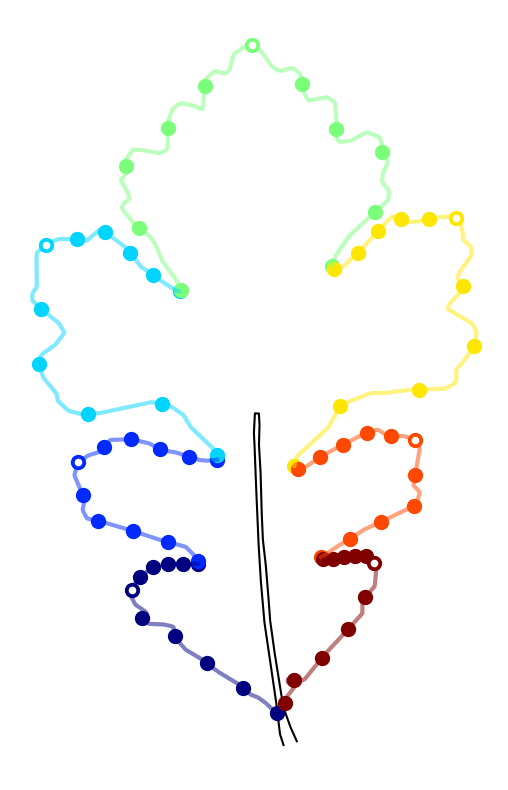

In [5]:
# get colors
cmap = cm.get_cmap('jet', num_lfts) 
pal = [] # store colors in palette
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    pal.append(matplotlib.colors.rgb2hex(rgba))

plt.figure(figsize=(10,10))

for i in range(num_lfts):
    plt.plot(lft_inter_arr[i,:,0],lft_inter_arr[i,:,1], lw=3, c=pal[i], alpha=0.5)
    plt.scatter(lft_inter_arr[i,:,0][::20],lft_inter_arr[i,:,1][::20], s=100, c=pal[i])
    plt.scatter(lft_inter_arr[i,:,0][-1],lft_inter_arr[i,:,1][-1], s=100, c=pal[i])
    plt.scatter(lft_inter_arr[i,:,0][lft_res],lft_inter_arr[i,:,1][lft_res], s=20, c="white",zorder=5)

plt.plot(axis[:,0], axis[:,1], c="k", zorder=0)
plt.gca().set_aspect("equal")
plt.axis("off")

# Plot transformed leaf

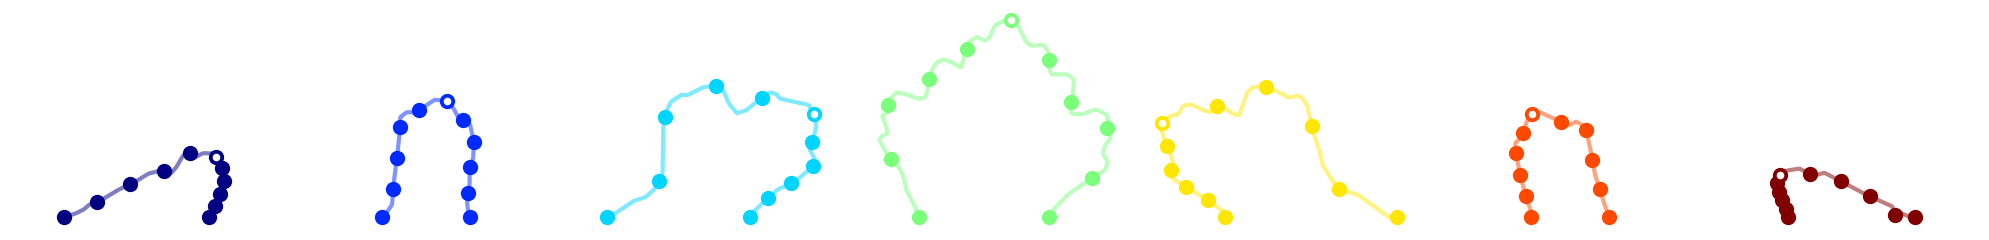

In [6]:
linewidth=3 # linewidth size
pt_sz = 100 # point size 
small_pt = 20 # small point size of tip
height = 2.5 # ADJUST HEIGHT FOR OPTIMAL RESOLUTION

fig, axs =plt.subplots(1,7,figsize=(20,2.5),sharey=True)

ax0 = axs[0]
ax0.plot(transf_lft[0,:,0],transf_lft[0,:,1], lw=linewidth, c=pal[0], alpha=0.5)
ax0.scatter(transf_lft[0,:,0][::20],transf_lft[0,:,1][::20], s=pt_sz, c=pal[0])
ax0.scatter(transf_lft[0,:,0][-1],transf_lft[0,:,1][-1], s=pt_sz, c=pal[0])
ax0.scatter(transf_lft[0,:,0][lft_res],transf_lft[0,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax0.axis("off")
ax0.set_aspect("equal", adjustable="datalim", anchor="SW")

ax1 = axs[1]
ax1.plot(transf_lft[1,:,0],transf_lft[1,:,1], lw=linewidth, c=pal[1], alpha=0.5)
ax1.scatter(transf_lft[1,:,0][::20],transf_lft[1,:,1][::20], s=pt_sz, c=pal[1])
ax1.scatter(transf_lft[1,:,0][-1],transf_lft[1,:,1][-1], s=pt_sz, c=pal[1])
ax1.scatter(transf_lft[1,:,0][lft_res],transf_lft[1,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax1.axis("off")
ax1.set_aspect("equal", adjustable="datalim", anchor="SW")

ax2 = axs[2]
ax2.plot(transf_lft[2,:,0],transf_lft[2,:,1], lw=linewidth, c=pal[2], alpha=0.5)
ax2.scatter(transf_lft[2,:,0][::20],transf_lft[2,:,1][::20], s=pt_sz, c=pal[2])
ax2.scatter(transf_lft[2,:,0][-1],transf_lft[2,:,1][-1], s=pt_sz, c=pal[2])
ax2.scatter(transf_lft[2,:,0][lft_res],transf_lft[2,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax2.axis("off")
ax2.set_aspect("equal", adjustable="datalim", anchor="SW")

ax3 = axs[3]
ax3.plot(transf_lft[3,:,0],transf_lft[3,:,1], lw=linewidth, c=pal[3], alpha=0.5)
ax3.scatter(transf_lft[3,:,0][::20],transf_lft[3,:,1][::20], s=pt_sz, c=pal[3])
ax3.scatter(transf_lft[3,:,0][-1],transf_lft[3,:,1][-1], s=pt_sz, c=pal[3])
ax3.scatter(transf_lft[3,:,0][lft_res],transf_lft[3,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax3.axis("off")
ax3.set_aspect("equal", adjustable="datalim", anchor="SW")

ax4 = axs[4]
ax4.plot(transf_lft[4,:,0],transf_lft[4,:,1], lw=linewidth, c=pal[4], alpha=0.5)
ax4.scatter(transf_lft[4,:,0][::20],transf_lft[4,:,1][::20], s=pt_sz, c=pal[4])
ax4.scatter(transf_lft[4,:,0][-1],transf_lft[4,:,1][-1], s=pt_sz, c=pal[4])
ax4.scatter(transf_lft[4,:,0][lft_res],transf_lft[4,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax4.axis("off")
ax4.set_aspect("equal", adjustable="datalim", anchor="SW")

ax5 = axs[5]
ax5.plot(transf_lft[5,:,0],transf_lft[5,:,1], lw=linewidth, c=pal[5], alpha=0.5)
ax5.scatter(transf_lft[5,:,0][::20],transf_lft[5,:,1][::20], s=pt_sz, c=pal[5])
ax5.scatter(transf_lft[5,:,0][-1],transf_lft[5,:,1][-1], s=pt_sz, c=pal[5])
ax5.scatter(transf_lft[5,:,0][lft_res],transf_lft[5,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax5.axis("off")
ax5.set_aspect("equal", adjustable="datalim", anchor="SW")

ax6 = axs[6]
ax6.plot(transf_lft[6,:,0],transf_lft[6,:,1], lw=linewidth, c=pal[6], alpha=0.5)
ax6.scatter(transf_lft[6,:,0][::20],transf_lft[6,:,1][::20], s=pt_sz, c=pal[6])
ax6.scatter(transf_lft[6,:,0][-1],transf_lft[6,:,1][-1], s=pt_sz, c=pal[6])
ax6.scatter(transf_lft[6,:,0][lft_res],transf_lft[6,:,1][lft_res], s=small_pt, c="white",zorder=5)
ax6.axis("off")
ax6.set_aspect("equal", adjustable="datalim", anchor="SW")

fig.tight_layout()


# Plot reconstructed leaf

In [7]:
recon_num = 5 # number of leaflets to reconstruct

recon_lfts = np.linspace(0,num_lfts-1,recon_num)

recon_lfts_x = []
recon_lfts_y = []

for i in recon_lfts:
    
    recon_lft_x = []
    recon_lft_y = []
    
    for j in range(coord_num):
        recon_lft_x.append(polydeg2(i,x_arr[j,0],x_arr[j,1],x_arr[j,2]))
        recon_lft_y.append(polydeg2(i,y_arr[j,0],y_arr[j,1],y_arr[j,2]))
        
    
    recon_lfts_x.append(recon_lft_x)
    recon_lfts_y.append(recon_lft_y)

/var/folders/_x/9rzw8tw527l5dl39m6gjjskm0000gn/T/ipykernel_20912/1093620118.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', recon_num)


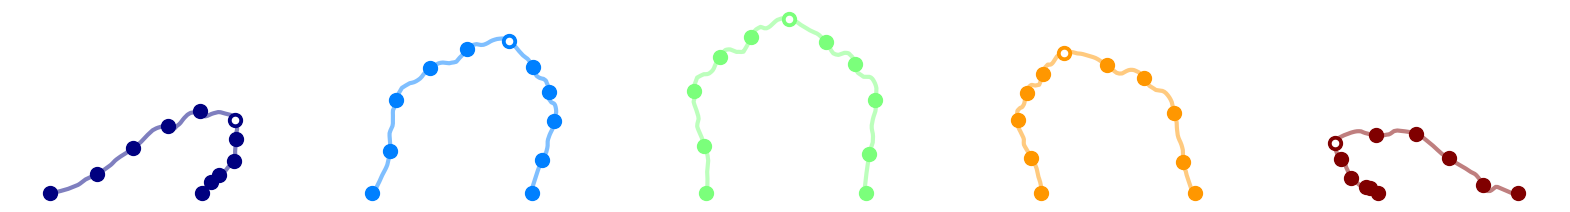

In [8]:
# get colors
cmap = cm.get_cmap('jet', recon_num) 
pal = [] # store colors in palette
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    pal.append(matplotlib.colors.rgb2hex(rgba))
    
linewidth=3 # linewidth size
pt_sz = 100 # point size 
small_pt = 20 # small point size of tip
height = 2.5 # ADJUST HEIGHT FOR OPTIMAL RESOLUTION

fig, axs =plt.subplots(1,5,figsize=(20,2.5),sharey=True)

ax0 = axs[0]
ax0.plot(recon_lfts_x[0],recon_lfts_y[0], lw=linewidth, c=pal[0], alpha=0.5)
ax0.scatter(recon_lfts_x[0][::20],recon_lfts_y[0][::20], s=pt_sz, c=pal[0])
ax0.scatter(recon_lfts_x[0][-1],recon_lfts_y[0][-1], s=pt_sz, c=pal[0])
ax0.scatter(recon_lfts_x[0][lft_res],recon_lfts_y[0][lft_res], s=small_pt, c="white",zorder=5)
ax0.axis("off")
ax0.set_aspect("equal", adjustable="datalim", anchor="SW")

ax1 = axs[1]
ax1.plot(recon_lfts_x[1],recon_lfts_y[1], lw=linewidth, c=pal[1], alpha=0.5)
ax1.scatter(recon_lfts_x[1][::20],recon_lfts_y[1][::20], s=pt_sz, c=pal[1])
ax1.scatter(recon_lfts_x[1][-1],recon_lfts_y[1][-1], s=pt_sz, c=pal[1])
ax1.scatter(recon_lfts_x[1][lft_res],recon_lfts_y[1][lft_res], s=small_pt, c="white",zorder=5)
ax1.axis("off")
ax1.set_aspect("equal", adjustable="datalim", anchor="SW")

ax2 = axs[2]
ax2.plot(recon_lfts_x[2],recon_lfts_y[2], lw=linewidth, c=pal[2], alpha=0.5)
ax2.scatter(recon_lfts_x[2][::20],recon_lfts_y[2][::20], s=pt_sz, c=pal[2])
ax2.scatter(recon_lfts_x[2][-1],recon_lfts_y[2][-1], s=pt_sz, c=pal[2])
ax2.scatter(recon_lfts_x[2][lft_res],recon_lfts_y[2][lft_res], s=small_pt, c="white",zorder=5)
ax2.axis("off")
ax2.set_aspect("equal", adjustable="datalim", anchor="SW")

ax3 = axs[3]
ax3.plot(recon_lfts_x[3],recon_lfts_y[3], lw=linewidth, c=pal[3], alpha=0.5)
ax3.scatter(recon_lfts_x[3][::20],recon_lfts_y[3][::20], s=pt_sz, c=pal[3])
ax3.scatter(recon_lfts_x[3][-1],recon_lfts_y[3][-1], s=pt_sz, c=pal[3])
ax3.scatter(recon_lfts_x[3][lft_res],recon_lfts_y[3][lft_res], s=small_pt, c="white",zorder=5)
ax3.axis("off")
ax3.set_aspect("equal", adjustable="datalim", anchor="SW")

ax4 = axs[4]
ax4.plot(recon_lfts_x[4],recon_lfts_y[4], lw=linewidth, c=pal[4], alpha=0.5)
ax4.scatter(recon_lfts_x[4][::20],recon_lfts_y[4][::20], s=pt_sz, c=pal[4])
ax4.scatter(recon_lfts_x[4][-1],recon_lfts_y[4][-1], s=pt_sz, c=pal[4])
ax4.scatter(recon_lfts_x[4][lft_res],recon_lfts_y[4][lft_res], s=small_pt, c="white",zorder=5)
ax4.axis("off")
ax4.set_aspect("equal", adjustable="datalim", anchor="SW")
